# Online Shopping Behaviour / Intention Prediction
#### Tjark Petersen, May 2020

Add a bit of narrative here...


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from joblib import dump

Using TensorFlow backend.


### Load data

In [4]:
df = pd.read_csv('../files/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
# delete the duration -1 cases
print(df[df.Administrative_Duration == -1].index)
print(df[df.Informational_Duration == -1].index)
print(df[df.ProductRelated_Duration == -1].index)

Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')


In [6]:
# delete these 33 cases 
df = df[df.Administrative_Duration != -1]

In [7]:
# binarize the label
df['Revenue'] = df['Revenue'].apply(lambda x: 1 if (x is True) else 0)

# split the data into train and test set
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Data Preprocessing & Feature Engineering

In [8]:
# custum transformation for numerical data

class SkewnessTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'numerical features'
        
    def feature_transform(self, df, func, add, columns=None):
        
        if columns is not None:
            df_temp = df[columns].astype('float64')
        else:
            df_temp = df.astype('float64')
        df_transformed = pd.DataFrame(df_temp.apply(lambda x: func(x+add)), columns = df_temp.columns)
        return df_transformed.values
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.feature_transform(df=X, func=np.log, add=0.001)
        return X
    

class InteractionTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'interactions of numerical features'
        
    def add_interaction(self, df, col_1, col_2):
        df['interaction'] = df[col_1] * df[col_2]
        return df
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.add_interaction(df=X, col_1='Administrative', col_2='PageValues')
        # print('num features', X.shape)
        return X.values

# currently not in use  
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__( self):
        self.name = 'categorical features'
    
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        # X = self.get_binary_weekend(df=X)
        # print('cat features', X.shape)
        # return X.values
        return self

In [9]:

cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
num_cols = ['Administrative',
             'Administrative_Duration',
             'Informational',
             'Informational_Duration',
             'ProductRelated',
             'ProductRelated_Duration',
             'BounceRates',
             'ExitRates',
             'PageValues',
             'SpecialDay']
label_col = ['Revenue']

categorical_pipeline = Pipeline( steps = [('one_hot_encoder', OneHotEncoder(handle_unknown='ignore') )])


numerical_pipeline = Pipeline( steps = [('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median') ),
                                        ('standardscaler', StandardScaler() )] )

numerical_pipeline_log = Pipeline( steps = [ ('log_transformer', SkewnessTransformer() ),
                                             ('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median') ),
                                             ('standardscaler', StandardScaler() )] )
                                    
plain_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

log_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_log, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

# Modelling & Evaluation

In [10]:
# create NN model
def create_NN():
    model = Sequential()
    model.add(Dense(70, input_dim=75, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# models
models = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter = 500),
    'GradientBoosting': GradientBoostingClassifier(), 
    'RandomForest': RandomForestClassifier(),
    'NN': KerasClassifier(build_fn=create_NN, epochs=10, batch_size=30, verbose=0)
}
models = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter = 500),
    'GradientBoosting': GradientBoostingClassifier(), 
}

In [11]:
def get_full_pipeline(processing, estimator):
    full_pipeline = Pipeline( steps = [ ( 'preprocessor', processing), ( 'model', estimator ) ] )
    return full_pipeline

feature_eng_options = {
    'plain': plain_pipeline,
    'log_transformed': log_pipeline
}

In [12]:
fitted_models = []
for processor_name, preprocessor in feature_eng_options.items():
    for model_name, model in models.items():
        full_pipeline = get_full_pipeline(processing=preprocessor, estimator=model)
        full_pipeline.fit(X_train, y_train)
        y_pred = full_pipeline.predict(X_test)
        print('---------------')
        print('Train Accuracy', model_name, processor_name, full_pipeline.score(X_train, y_train))
        print('Test Accuracy', model_name, processor_name, full_pipeline.score(X_test, y_test))
        print('Test F1', model_name, processor_name, f1_score(y_true=y_test, y_pred=y_pred))
        print('Test AUC', model_name, processor_name, roc_auc_score(y_true=y_test, y_score=y_pred))
        fitted_models.append({'model_name': model_name, 'preprocessor_name': processor_name, 'fitted_pipeline': full_pipeline})

---------------
Train Accuracy LogisticRegression plain 0.883466945509469
Test Accuracy LogisticRegression plain 0.891869918699187
Test F1 LogisticRegression plain 0.5501691093573844
Test AUC LogisticRegression plain 0.7043655778357715
---------------
Train Accuracy GradientBoosting plain 0.9183222958057395
Test Accuracy GradientBoosting plain 0.910840108401084
Test F1 GradientBoosting plain 0.686964795432921
Test AUC GradientBoosting plain 0.8011332659970639
---------------
Train Accuracy LogisticRegression log_transformed 0.89775763913094
Test Accuracy LogisticRegression log_transformed 0.9021680216802168
Test F1 LogisticRegression log_transformed 0.6571699905033239
Test AUC LogisticRegression log_transformed 0.7850477591890935
---------------
Train Accuracy GradientBoosting log_transformed 0.9183222958057395
Test Accuracy GradientBoosting log_transformed 0.9102981029810298
Test F1 GradientBoosting log_transformed 0.6850618458610847
Test AUC GradientBoosting log_transformed 0.8000822

# Final Model Selection & Evaluation

In [13]:
# select best model and preprocessing
model_index = 1
print(fitted_models[model_index])
final_pipeline = fitted_models[model_index].get('fitted_pipeline')

{'model_name': 'GradientBoosting', 'preprocessor_name': 'plain', 'fitted_pipeline': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('median_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                           

In [14]:
# train vs test set accuarcy
final_pipeline.score(X=X_train, y=y_train), final_pipeline.score(X=X_test, y=y_test)

(0.8855582665272452, 0.8924119241192412)

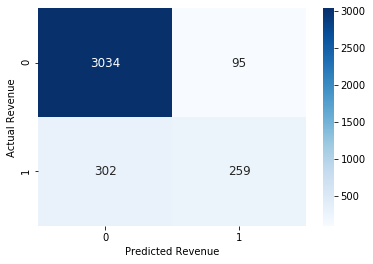

In [15]:
pred = final_pipeline.predict(X=X_test)
cm = confusion_matrix(y_true=y_test, y_pred=pred)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual Revenue'
df_cm.columns.name = 'Predicted Revenue'
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 12});

### Save model to disk

In [16]:
dump(final_pipeline, 'revenue_prediction_final_pipeline.joblib') 

['revenue_prediction_final_pipeline.joblib']

In [240]:
# store test data for expemlar http request
X_test.iloc[25,:].to_json('test_instance_0.json')
y_test.iloc[25]

0

In [245]:
cols = X_test.columns.tolist()
dump(cols, 'input_columns.joblib') 

['input_columns.joblib']